In [1]:
import torch
import sklearn
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, Dataset
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../src/datasets/')
sys.path.insert(1, '../src/pred/')

from model import gazetrack_model
from gazetrack_data import gazetrack_dataset

### Train SVR

In [3]:
weight_file = '../checkpoints/checkpoint.ckpt'
model = gazetrack_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w = torch.load(weight_file, map_location=device)['state_dict']
model.load_state_dict(w)
model.to(device)
model.eval()

gazetrack_model(
  (eye_model): eye_model(
    (model): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (4): Dropout(p=0.02, inplace=False)
      (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.01, inplace=True)
      (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (9): Dropout(p=0.02, inplace=False)
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (12): LeakyReLU(negative_slope=0.01, inplace=True)
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): Dropout(p=0.02, inplace=False)
    )

In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.combined_model[6].register_forward_hook(get_activation('out'))

In [5]:
def train_svr(file):
    dataset = gazetrack_dataset(file, phase="test")
    loader = DataLoader(
        dataset,
        batch_size=256,
        num_workers=8,
        pin_memory=False,
        shuffle=False,
    )

    preds, gt = [], []
    for j in tqdm(loader):
        leye, reye, kps, target = j[1].to(device), j[2].to(device), j[3].to(device), j[4].to(device)
        with torch.no_grad():
            pred = list(model(leye, reye, kps).cpu().detach().numpy())
        pred = list(activation["out"].detach().cpu().numpy())
        preds = preds + pred
        gt.extend(target.detach().cpu().numpy())

    gt = np.array(gt)
    preds = np.array(preds)

    reg = MultiOutputRegressor(SVR(kernel="rbf", C=20, gamma=0.06))
    
    reg.fit(preds, gt)
    
    return reg

In [6]:
f = '../data/converted_data/converted_042723-20:55:49_2/train/images/' # use this to train SVR
reg = train_svr(f)

Num files for test = 401


100%|██████████| 2/2 [00:21<00:00, 10.62s/it]


### Test SVR

In [7]:
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

In [8]:
def test_svr(file, reg): 
    test_dataset = gazetrack_dataset(file, phase="test")
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=256,
        num_workers=8,
        pin_memory=False,
        shuffle=False,
    )

    preds_pre, preds_final, gt = [], [], []
    for j in tqdm(test_dataloader): 
        leye, reye, kps, target = j[1].to(device), j[2].to(device), j[3].to(device), j[4].to(device)
        with torch.no_grad():
            pred = model(leye, reye, kps)
        pred = pred.detach().cpu().numpy()
        act = list(activation['out'].cpu().detach().numpy())

        pred_fin = reg.predict(act)

        preds_final.extend(pred_fin)
        preds_pre.extend(pred)
        gt.extend(target.cpu().detach().numpy())

    preds_pre = np.array(preds_pre)
    preds_final = np.array(preds_final)

    pts = np.unique(gt, axis=0)
    gt = np.array(gt)
    dist_pre = euc(preds_pre, gt)
    dist_final = euc(preds_final, gt)

    out = [preds_pre, preds_final, pts, gt, dist_pre, dist_final]

    return out

In [9]:
test_f_225539 = '../data/converted_data/converted_042523-22:55:39_2/train/images/' # use this to test SVR
out_225539 = test_svr(test_f_225539, reg)

Num files for test = 428


100%|██████████| 2/2 [00:22<00:00, 11.39s/it]


In [10]:
test_f_143234 = '../data/converted_data/converted_042523-14:32:34_2/train/images/'
out_143234 = test_svr(test_f_143234, reg)

Num files for test = 202


100%|██████████| 1/1 [00:14<00:00, 14.80s/it]


In [11]:
test_f_234924 = '../data/converted_data/converted_042723-23:49:24_2/train/images/'
out_234924 = test_svr(test_f_234924, reg)

Num files for test = 496


100%|██████████| 2/2 [00:21<00:00, 10.56s/it]


In [12]:
preds_pre1, preds_final1, pts1, gt1, dist_pre1, dist_final1 = out_225539
preds_pre2, preds_final2, pts2, gt2, dist_pre2, dist_final2 = out_143234
preds_pre3, preds_final3, pts3, gt3, dist_pre3, dist_final3 = out_234924

In [13]:
print("all these have 6 frames after each dot onset removed")
print("before svr for 042523-20:55:39: ", np.mean(dist_pre1))
print("after svr for 042523-20:55:39: ", np.mean(dist_final1))
print("before svr for 042523-14:32:34: ", np.mean(dist_pre2))
print("after svr for 042523-14:32:34: ", np.mean(dist_final2))
print("before svr for 042723-23:49:24: ", np.mean(dist_pre3))
print("after svr for 042723-23:49:24: ", np.mean(dist_final3))

all these have 6 frames after each dot onset removed
before svr for 042523-20:55:39:  2.4049656
after svr for 042523-20:55:39:  1.1462859161091923
before svr for 042523-14:32:34:  1.9978203
after svr for 042523-14:32:34:  0.832355852030275
before svr for 042723-23:49:24:  2.2287614
after svr for 042723-23:49:24:  1.3818979424634132


### Error Distributions (SVR Before & After)

Text(0.5, 1.0, 'error distribution for \n042523-22:55:39 (after SVR)')

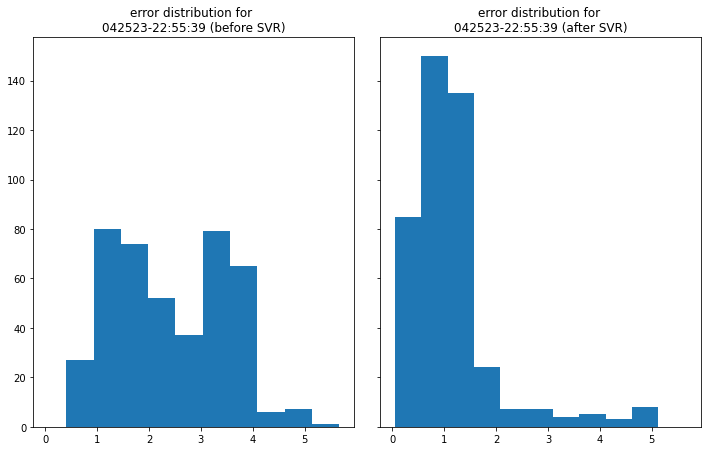

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
plt.tight_layout()
ax[0].hist(dist_pre1, bins=10)
ax[0].set_title("error distribution for \n042523-22:55:39 (before SVR)")
ax[1].hist(dist_final1, bins=10)
ax[1].set_title("error distribution for \n042523-22:55:39 (after SVR)")

Text(0.5, 1.0, 'error distribution for \n042523-14:32:34 (after SVR)')

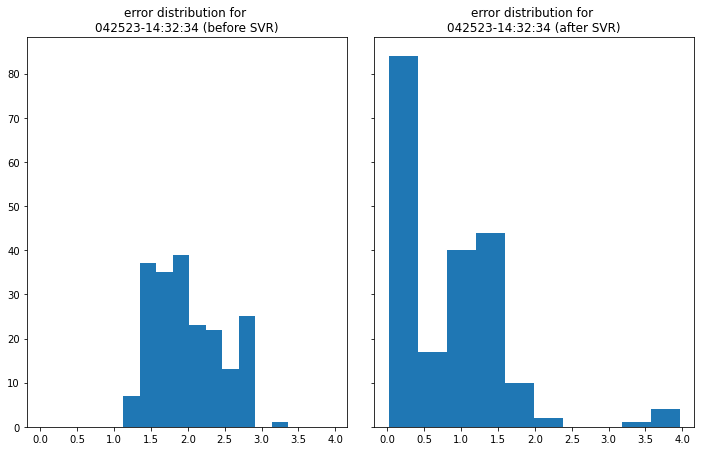

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
plt.tight_layout()
ax[0].hist(dist_pre2, bins=10)
ax[0].set_title("error distribution for \n042523-14:32:34 (before SVR)")
ax[1].hist(dist_final2, bins=10)
ax[1].set_title("error distribution for \n042523-14:32:34 (after SVR)")

The below plot is of the predictions of previously unseen calibration points

Text(0.5, 1.0, 'error distribution for \n042523-23:49:24 (after SVR)')

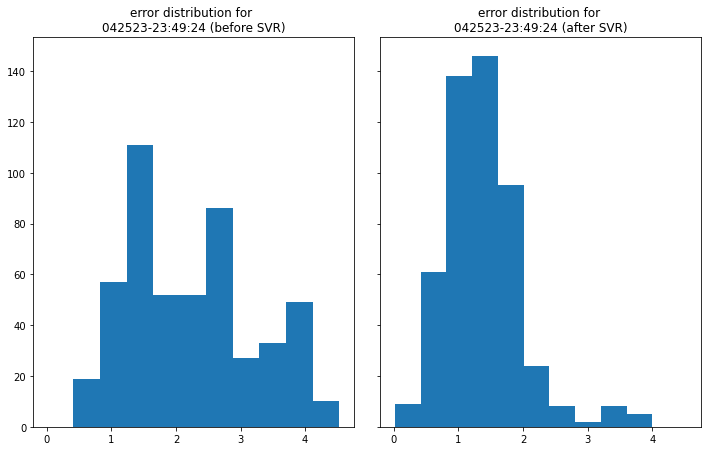

In [16]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 6))
plt.tight_layout()
ax[0].hist(dist_pre3, bins=10)
ax[0].set_title("error distribution for \n042523-23:49:24 (before SVR)")
ax[1].hist(dist_final3, bins=10)
ax[1].set_title("error distribution for \n042523-23:49:24 (after SVR)")

### Visualize Prediction Points & Ground Truth Labels (Before & After SVR)

for 22:55:39 -

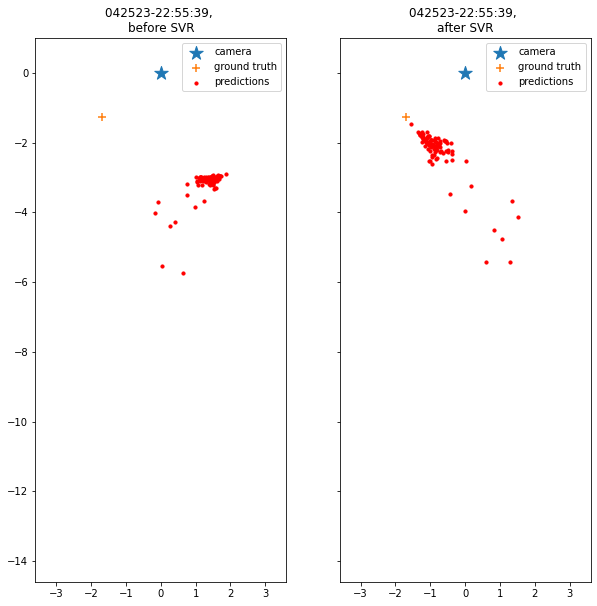

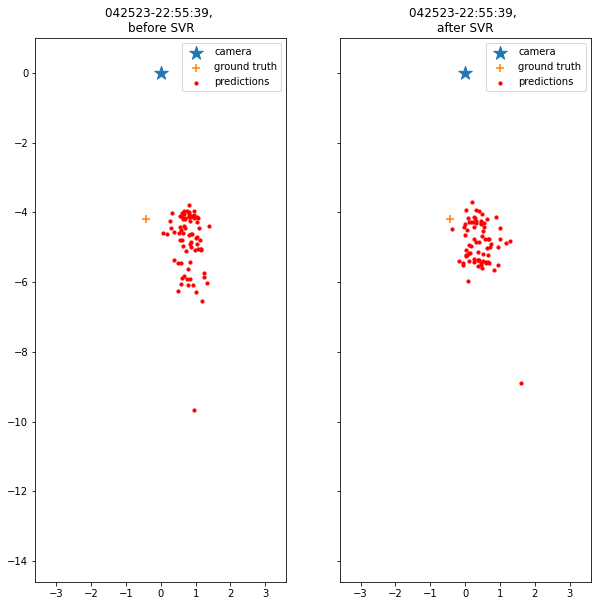

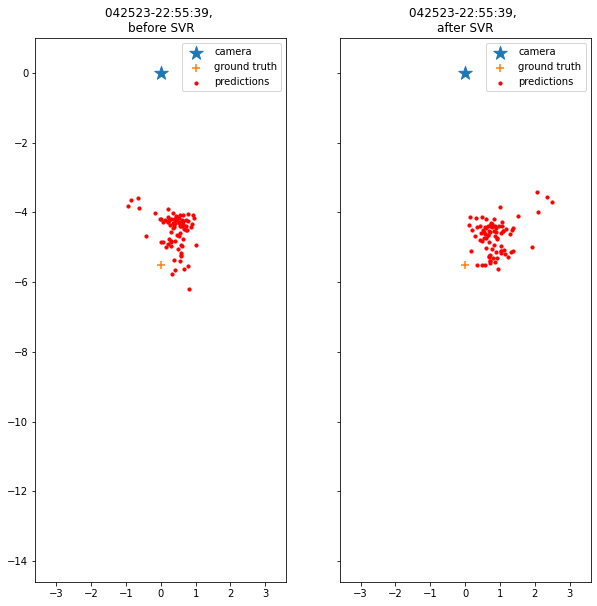

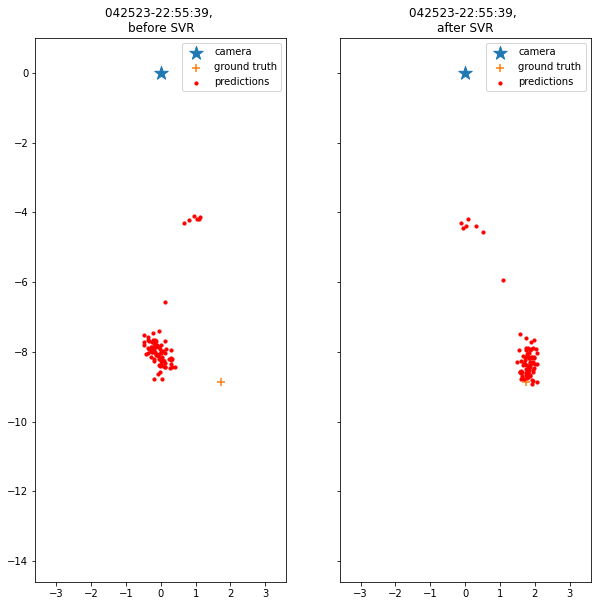

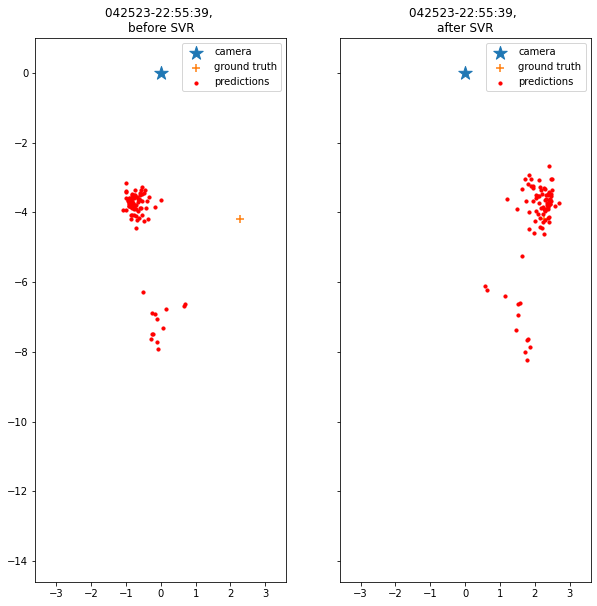

In [17]:
for i in range(len(pts1)): 
    points = preds_pre1[np.where(np.all(gt1==pts1[i], axis=1))]
    fig, axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 10))
    ax1, ax2 = axes
    ax1.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax1.scatter(pts1[i][0], pts1[i][1], marker = '+', s = 50, label = 'ground truth')
    ax1.scatter(points[:, 0], points[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax1.set_xlim(-3.6, 3.6)
    ax1.set_ylim(-14.6, 1)
    ax1.set_aspect('equal')
    ax1.legend()
    ax1.set_title("042523-22:55:39, \nbefore SVR")

    points2 = preds_final1[np.where(np.all(gt1==pts1[i], axis=1))]
    ax2.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax2.scatter(pts1[i][0], pts1[i][1], marker = '+', s = 50, label = 'ground truth')
    ax2.scatter(points2[:, 0], points2[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax2.set_xlim(-3.6, 3.6)
    ax2.set_ylim(-14.6, 1)
    ax2.set_aspect('equal')
    ax2.legend()
    ax2.set_title("042523-22:55:39, \nafter SVR")

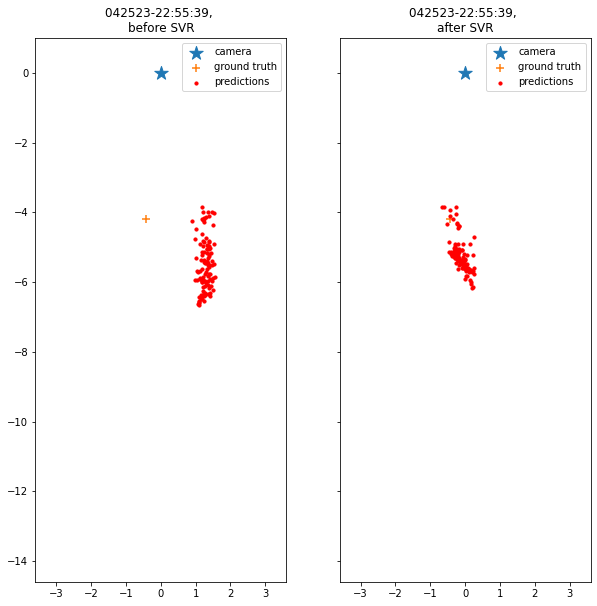

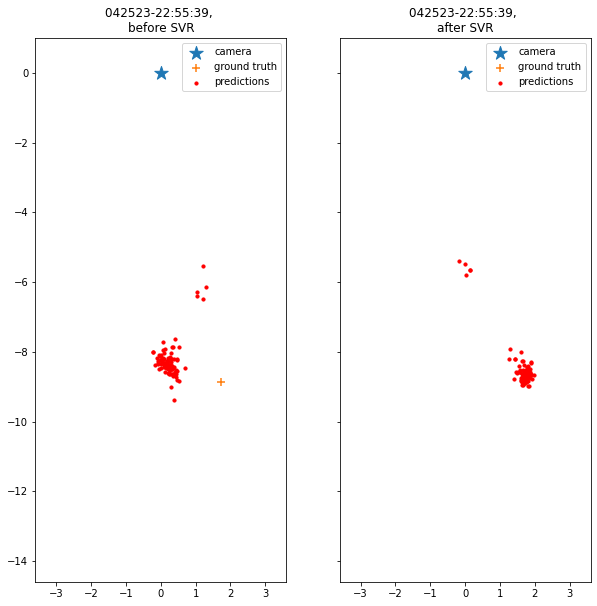

In [18]:
for i in range(len(pts2)): 
    points = preds_pre2[np.where(np.all(gt2==pts2[i], axis=1))]
    fig, axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 10))
    ax1, ax2 = axes
    ax1.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax1.scatter(pts2[i][0], pts2[i][1], marker = '+', s = 50, label = 'ground truth')
    ax1.scatter(points[:, 0], points[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax1.set_xlim(-3.6, 3.6)
    ax1.set_ylim(-14.6, 1)
    ax1.set_aspect('equal')
    ax1.legend()
    ax1.set_title("042523-22:55:39, \nbefore SVR")

    points2 = preds_final2[np.where(np.all(gt2==pts2[i], axis=1))]
    ax2.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax2.scatter(pts2[i][0], pts2[i][1], marker = '+', s = 50, label = 'ground truth')
    ax2.scatter(points2[:, 0], points2[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax2.set_xlim(-3.6, 3.6)
    ax2.set_ylim(-14.6, 1)
    ax2.set_aspect('equal')
    ax2.legend()
    ax2.set_title("042523-22:55:39, \nafter SVR")

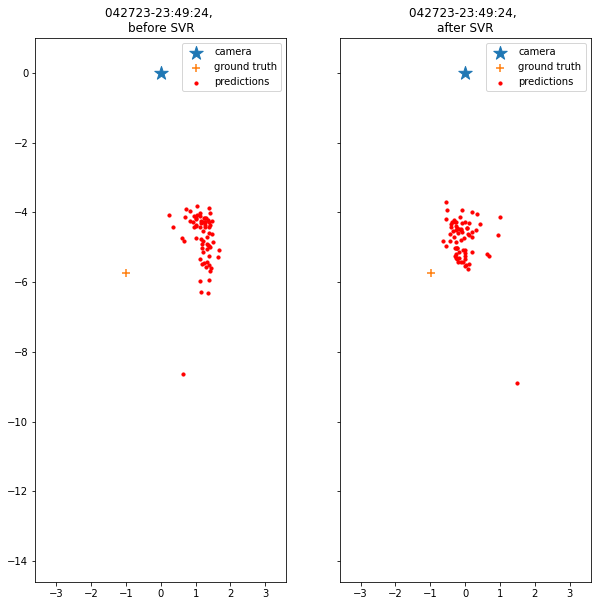

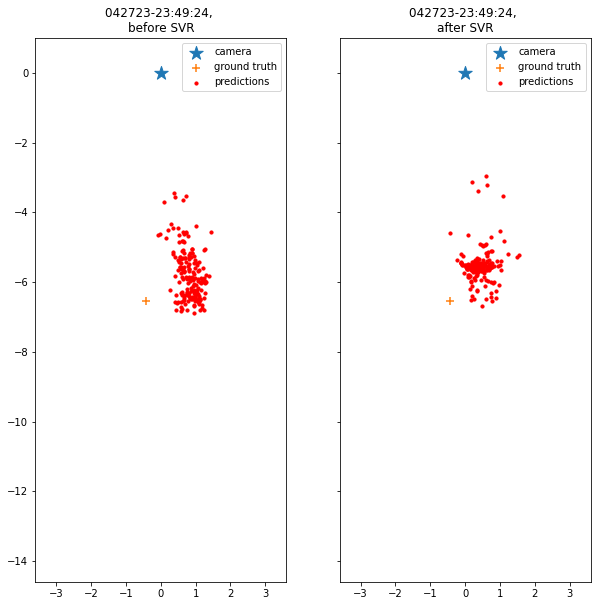

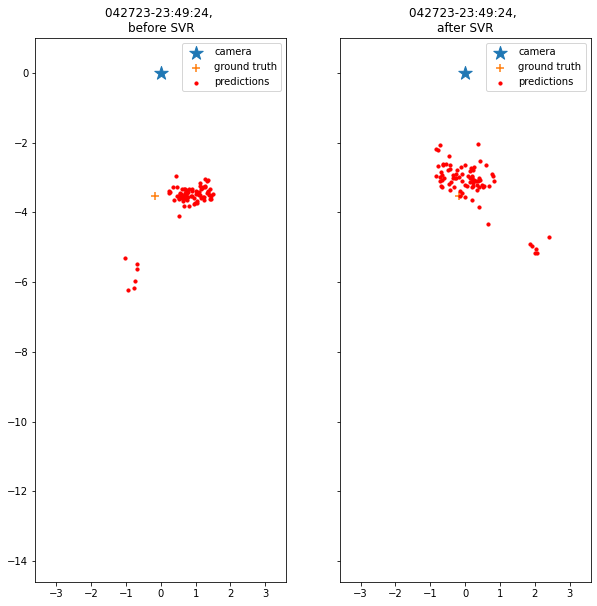

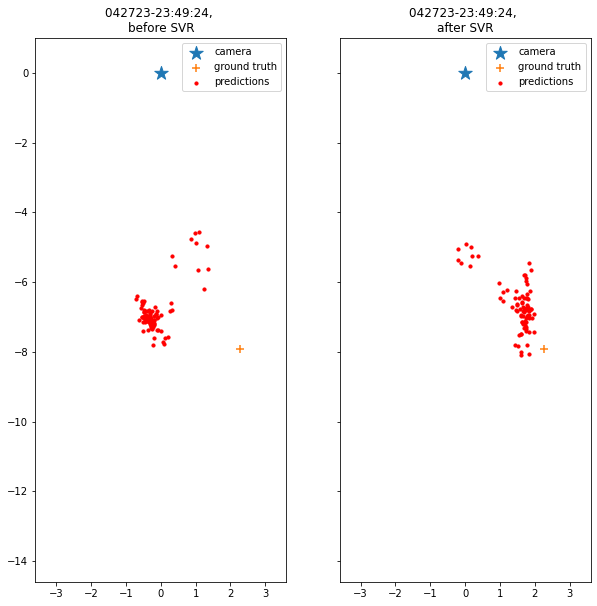

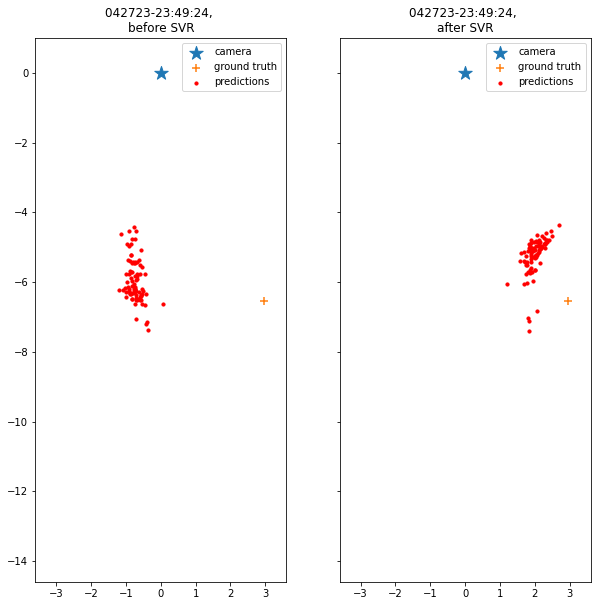

In [19]:
for i in range(len(pts3)): 
    points = preds_pre3[np.where(np.all(gt3==pts3[i], axis=1))]
    fig, axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 10))
    ax1, ax2 = axes
    ax1.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax1.scatter(pts3[i][0], pts3[i][1], marker = '+', s = 50, label = 'ground truth')
    ax1.scatter(points[:, 0], points[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax1.set_xlim(-3.6, 3.6)
    ax1.set_ylim(-14.6, 1)
    ax1.set_aspect('equal')
    ax1.legend()
    ax1.set_title("042723-23:49:24, \nbefore SVR")

    points2 = preds_final3[np.where(np.all(gt3==pts3[i], axis=1))]
    ax2.scatter(0, 0, marker = '*', s = 200, label = 'camera')
    ax2.scatter(pts3[i][0], pts3[i][1], marker = '+', s = 50, label = 'ground truth')
    ax2.scatter(points2[:, 0], points2[:, 1], marker = 'o', c = 'r', s = 10, label = 'predictions')
    ax2.set_xlim(-3.6, 3.6)
    ax2.set_ylim(-14.6, 1)
    ax2.set_aspect('equal')
    ax2.legend()
    ax2.set_title("042723-23:49:24, \nafter SVR")